# **Waze Project**
**Course 6 - The nuts and bolts of machine learning**

# **Course 6 End-of-Course Project: Build a machine learning model**

**Part 1:** Model Building and Evaluation

**Part 2:** Interpreting Model Results

# **Build a machine learning model**


### **Imports and data loading**

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle

In [2]:
df = pd.read_csv('dataset_encoded_features.csv')

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,drives_per_driving_day,total_sessions_per_day,km_per_drive,is_churned,device_Android,device_iPhone
0,0,0,0,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,0.95,10.526316,0.130381,13.144225,0,1,0
1,1,1,1,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,1246.901868,0.41,9.727273,0.266854,83.165573,0,0,1
2,2,2,2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,0.84,11.875000,0.051121,32.201567,0,1,0
3,3,3,3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,0.72,13.333333,4.505948,22.839778,0,0,1
4,4,4,4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,0.50,3.777778,0.107713,58.091206,0,1,0


### **Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

In [74]:
df.drop(columns=["ID", "Unnamed: 0.1", "Unnamed: 0"], inplace=True)
df.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,drives_per_driving_day,total_sessions_per_day,km_per_drive,is_churned,device_Android,device_iPhone
0,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,0.95,10.526316,0.130381,13.144225,0,1,0
1,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,1246.901868,0.41,9.727273,0.266854,83.165573,0,0,1
2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,0.84,11.875000,0.051121,32.201567,0,1,0
3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,0.72,13.333333,4.505948,22.839778,0,0,1
4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,0.50,3.777778,0.107713,58.091206,0,1,0


### **Modeling workflow and model selection process**

### **Split the data**

In [9]:
X = df.copy().drop(columns=["is_churned"])
y = df["is_churned"]
X_, X_test, y_, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_, y_, stratify=y_,
                                                  test_size=0.25, random_state=42)

In [7]:
print(y_train.shape, y_test.shape, y_val.shape)

(7938,) (2646,) (2646,)


### **Modeling**

In [67]:
rf = RandomForestClassifier(random_state=2)
cv_params = {
    'max_depth': [3, 5, 10, 15, None],
    'max_features': [1.0],
    'max_samples': [1.0],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2],
    'n_estimators': [100, 150, 300],
}

scoring = ["accuracy", "f1", "precision", "recall"]
rf_cv = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=5, refit="recall")

In [68]:
%%time
rf_cv.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

KeyboardInterrupt: 

In [21]:
rf_cv.best_score_

0.11086784201175344

Examine the best combination of hyperparameters.

In [22]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [23]:
def make_results(model_name, model_object, metric):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [25]:
results = make_results('Random Forest: train', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389


The results aren't particularly good. Most of the metrics, aside from accuracy, are pretty low

#### **XGBoost**

In [32]:
xgb = XGBClassifier(objective='binary:logistic', random_state=912)
cv_params = {
    'max_depth': [3, 5, 6, 12],
    'min_child_weight': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 150, 200, 300]
}
scoring = ["accuracy", "f1", "precision", "recall"]
xgb_cv = GridSearchCV(estimator=xgb, param_grid=cv_params, scoring=scoring, cv=5, refit="recall")

In [33]:
%%time
xgb_cv.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

CPU times: user 6min 59s, sys: 2min 43s, total: 9min 42s
Wall time: 1min 18s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=912, ...),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 5, 6, 12], 'min_child_weight': [3, 5],
                         'n_estimators': [100, 150, 200, 300]},
             refit='recall', scoring=['accuracy', 'f1', 'precision', 'recall'])

In [34]:
xgb_cv.best_score_

0.1537406040727074

In [35]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [36]:
xgb_cv_results = make_results('XGB: train', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427


This model fit the data better than the random forest model. The recall score is 4% larger than the random forest model, so is F1, precision is 6% lower, while accuracy remains similar

### **Model selection**

#### **Random forest**

In [37]:
rf_val_prdictions = rf_cv.predict(X_val)

In [38]:
def get_test_scores(model_name, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [39]:
rf_val_df = get_test_scores("RF cv: validation", rf_val_prdictions, y_val)
results = pd.concat([results, rf_val_df], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427
0,RF cv: validation,0.491803,0.133038,0.209424,0.828798


#### **XGBoost**

In [40]:
xgb_val_predictions = xgb_cv.predict(X_val)

xgb_val_df = get_test_scores("XGB cv: validation", xgb_val_predictions, y_val)
results = pd.concat([results, xgb_val_df], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427
0,RF cv: validation,0.491803,0.133038,0.209424,0.828798
0,XGB cv: validation,0.430168,0.170732,0.244444,0.820106


The XGBoost model's validation scores are mostly higher that those of RF. It is still the clear champion.

### **Use champion model to predict on test data**


In [41]:
xgb_test_predictions = xgb_cv.predict(X_test)
xgb_test_df = get_test_scores("XGB cv: test", xgb_test_predictions, y_test)
results = pd.concat([results, xgb_test_df], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427
0,RF cv: validation,0.491803,0.133038,0.209424,0.828798
0,XGB cv: validation,0.430168,0.170732,0.244444,0.820106
0,XGB cv: test,0.421053,0.159645,0.231511,0.819350


### **Confusion matrix**

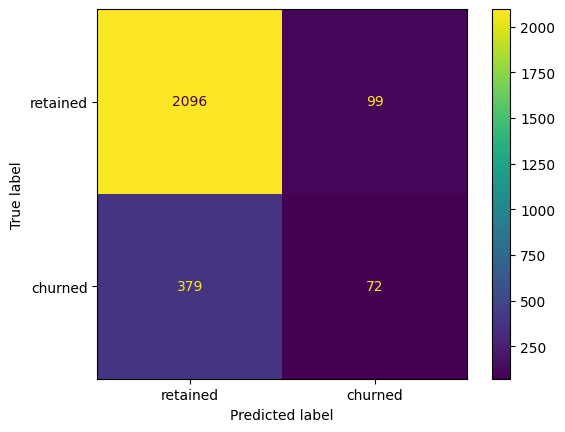

In [42]:
cm = confusion_matrix(y_test, xgb_test_predictions, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot()

In [82]:
target_labels = ['retained', 'churned']
print(classification_report(y_test, xgb_test_predictions, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.85      0.95      0.90      2195
     churned       0.42      0.16      0.23       451

    accuracy                           0.82      2646
   macro avg       0.63      0.56      0.56      2646
weighted avg       0.77      0.82      0.78      2646



The model predicted four times as many false negatives than it did false positives, and it correctly identified only 16% of the users who actually churned.

### **Feature importance**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

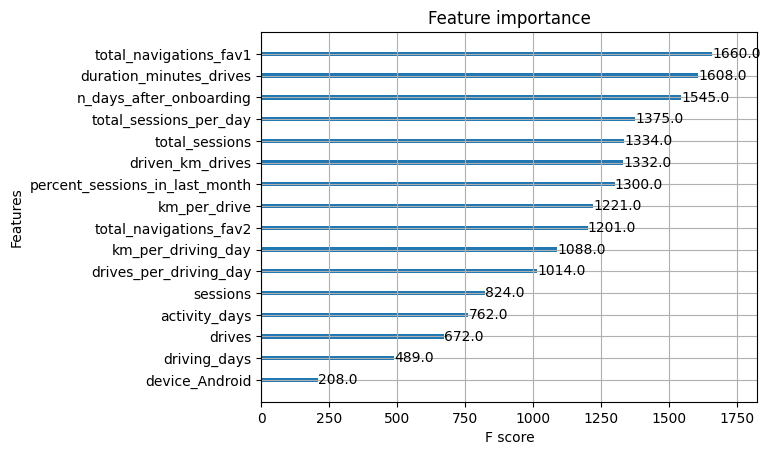

In [43]:
plot_importance(xgb_cv.best_estimator_)

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (`activity_days`) very heavily in its final prediction.

### **Survival Random Forest**

# можешь написать, зачем он? в идеале расписать че в коде происходит(

Логичным кажется не классифицировать уже отвалившихся клиентов, а пытаться предсказать когда клиент отвалится. Событие - человек отваливается. В конкретно этой задаче не очень понятно за что клиент платит, но допустим за сессии или день с момента регистрации (обычно, это не сложно выяснить). Я выбрал сессии. С этой точки зрения наши данные о не отвалившихся клиентах - зацензурированы (это значит что мы не знаем время события (отваливания), мы только знаем что он не отвалился до сих пор (оценку на это время снизу). То есть мы могли бы решать задачу регрессии на людях которые отвалились: входные данные - всё что мы знаем о человеке кроме сессии - выходные данные сессия на которой он отвалился. Потом вкидывать входные данные кроме сессии и получать сессию на которой человек отвалится. (Это всё очень упрошенно) Но мы хотим ещё использовать зацензуированные данные людей которые не отвалились. Вот сюрвайвал рандом форест решает похожуй задачу, даже больше - он предсказывает всю сюрвайвал кривую (вероятность дожить до момента т). В идеале на каждом листе дерева клиенты с одинаковыми сюрвайвал кривыми.

In [2]:
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

In [3]:
df = pd.read_csv('waze_dataset_no_nans_outlier_to_95th_p.csv').dropna()
y = pd.concat([df['label'].map({'retained' :False, 'churned':True}).astype(bool),df['sessions'].astype(float)],axis=1) #Перекодирую лейбл ("retained" - False, т.к событие ещё не наступило 'churned' - соответственно True)
#y = (bool - событие наступило или нет,float-время регистрации( в данном случае сессии, но можно что другое выбрать))
dtype = [('event', bool), ('time', float)]
y=np.array(list(zip(df['label'].map({'retained' :False, 'churned':True}).astype(bool),df['sessions'].astype(float))),dtype=dtype)
X = df.drop(columns=['label','sessions','ID','device','drives','total_sessions'])
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.25, random_state=45)

In [4]:
random_state = 20
rsf = RandomSurvivalForest(
    n_estimators=100, min_samples_split=15, min_samples_leaf=10, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=15, n_jobs=-1,
                     random_state=20)

Survival random forest returns 'risk'. In many applications, it is more useful than a classification task, as the organization can often proactively engage with high-risk users to improve retention.

# можешь расписать, что такое риск? как он формально определяется и для наших данных? ресурсы добавить?

Смотри каждому листу дерева мы сопоставили клиентов с одиноковами сюрвайвал кривыми. Просто чтоб выдать число характеризующую кривую - считают риск. Если кумулятивную хазард функциюю для листа обозначить за H, тогда риск = \sum^N_i H(T_i) сумма по всем клиентам классифицированным в нод. Это же равно "expected number of events for one particular terminal node". Я переделал предпоследнюю картинку подписав риск - можешь посмотреть чем выше риск, тем быстрее спадает сюрвайвал кривая. Оригинальная статья (https://arxiv.org/pdf/0811.1645.pdf). Вообще про риск можно по простому думать как про ранк, если у одного клиента рриск больше чем у другого, то он скорее быстрее отвалится

In [12]:
event_indicator = y_val['event']
event_time = y_val['time']
prediction = rsf.predict(X_val)
result = concordance_index_censored(event_indicator, event_time, prediction)
print(result)

(0.793439216677776, 863004, 224671, 0, 16367)


We see Concordance_index  0.71, that is pretty high result.

# что такое конкорданс индекс? ну да он высокий а что это дает? я думаю, что надо писать из пресуппозиций, что это не супер база и объяснять больше (ну и мне тоже, я не понимаю здесь ничего!)
как минимум можно общий теор смысл по-русски и что эти метрки говорят о данных, я переведу и оформлю

https://square.github.io/pysurvival/metrics/c_index.html, https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html. Метрики говорят, что мы хорошо проранжировали риском клиентов, больше риск- раньше отвалился.

In [6]:

prediction = rsf.predict(X_train)
result_df = pd.DataFrame({'event_time':y_train['time'],'prediction':prediction,'label':y_train['event']})


In [7]:
from sklearn.linear_model import LogisticRegression
X=prediction.reshape(-1, 1)
clf = LogisticRegression().fit(X, y_train['event'])

# а вот тут для чего линия?

Ну мы имеем риски, что збс, но изначально была задача классификации. По рискам трейна - и лэйблу, строю логистическую регресию чтоб найти значение риска ниже которого с 0.5 вероятностью остался а с 0.5 вероятностью отвалился. Линия - отмечает это число "Select a decision boundary to move from risk to classification. This time, we used logistic regression to do it." Но согласен написал плохо

C:\Users\Acer\anaconda3\envs\Nastya_data_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


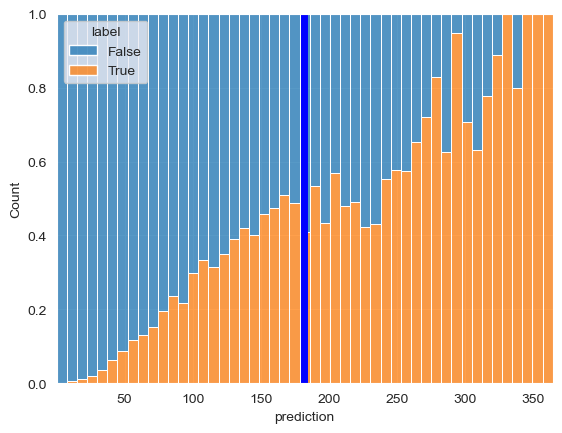

In [8]:
x_values = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
coef = clf.coef_[0]
intercept = clf.intercept_[0]
decision_boundary = -intercept/coef
fig,ax= plt.subplots(1)
sns.histplot(result_df, hue='label',x='prediction',multiple='fill',ax=ax)
ax.axvline(decision_boundary,linewidth=5,color = 'b')

# непонятно, что ниже написано(

To begin, we can see that the model was trained properly; on the train set, a bigger risk means a higher chance of churn. Select a decision boundary to move from risk to classification. This time, we used logistic regression to do it. It's common for businesses to want more false results in this job. For example, if we set a boundary for people with whom proactive interaction is planned.

In [9]:
from sklearn.inspection import permutation_importance
perm_import = permutation_importance(rsf, X_val, y_val, n_repeats=15, random_state=random_state)
pd.DataFrame(
    {
        k: perm_import[k]
        for k in (
        "importances_mean",
        "importances_std",
    )
    },
    index=X_val.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
percent_sessions_in_last_month,0.103818,0.005665
activity_days,0.050269,0.006813
n_days_after_onboarding,0.020466,0.003614
driving_days,0.003363,0.002933
duration_minutes_drives,0.001779,0.001196
Unnamed: 0,0.000032,0.001789
total_navigations_fav2,-0.000140,0.000910
total_navigations_fav1,-0.000463,0.001927
driven_km_drives,-0.000640,0.000918
km_per_driving_day,-0.004273,0.001898


In [10]:
prediction = rsf.predict(X_val)
y_true = np.array(y_val['event'])  # True labels
y_pred = prediction>decision_boundary  # Predicted labels

# Convert boolean arrays to integer type
y_true_int = y_true.astype(int)
y_pred_int = y_pred.astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true_int, y_pred_int)
print(classification_report(y_true_int, y_pred_int))
print(cm)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2953
           1       0.42      0.17      0.24       622

    accuracy                           0.81      3575
   macro avg       0.63      0.56      0.57      3575
weighted avg       0.77      0.81      0.78      3575

[[2805  148]
 [ 517  105]]


# почему ризонабл?

Ну мы риски(которые не случайны) более менее предсказали С индекс.- можно ещё метри модели построить https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html. Помимо риска - когда именно клиент решит отвалиться - полностью случайно(). Понятно что случайную часть мы предсказать не можем лучше чем с 0.5 вероятностью. Классификатор построенный на нашем знаний о рисках выдал такой же результат, поэтому может лучше и нельзя. Конечно это не доказательство, но тут проще по зуму обсудить.

We see that this model shows the same results as previous tree-classifiers. A rather high C-index indicates that it could be a reasonable result for this dataset.

# ниже тоже ничего вообще не понимаю

Давай завтра обсудим последний кусок

In [13]:
surv = rsf.predict_survival_function(X_val, return_array=True)
prediction = rsf.predict(X_val)

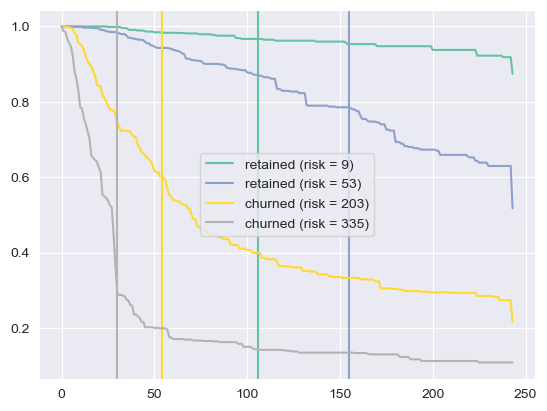

In [31]:
inverse_map= {False:'retained',True:'churned'}
values = [9,178,151,83]
colormap = plt.cm.Set2
color_list = colormap(np.linspace(0, 1, len(values)))
for idx, val in enumerate(values):
    plt.plot(np.arange(len(rsf.unique_times_)),surv[val,:],label=f'{inverse_map[y_val[val][0]]} (risk = {prediction[val]:.0f})',color=color_list[idx])
    plt.axvline(y_val[val][1],color=color_list[idx])
plt.legend()

Additionally the whole survival curve can be predicted for each participant.

C:\Users\Acer\AppData\Local\Temp\ipykernel_23728\2634362436.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob[idx] = surv[i,int(timepoint[idx])]
C:\Users\Acer\anaconda3\envs\Nastya_data_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Acer\AppData\Local\Temp\ipykernel_23728\2634362436.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob[idx] = surv[i,int(timepoint[idx])]
C:\Users\Acer\anaconda3\envs\Nastya_data_analysis\L

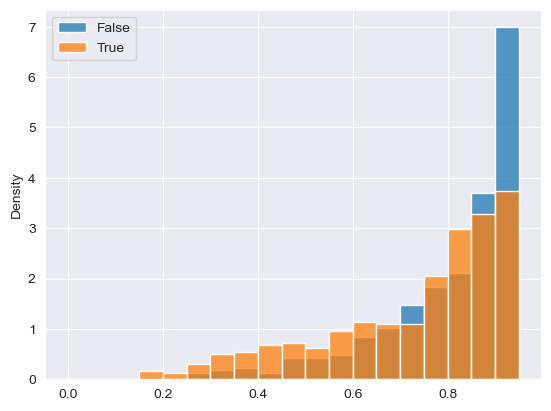

In [196]:
bins= np.arange(20)*0.05
for label in range(2):
    times=y_val[y_val['event']==label]['time']
    timepoint = np.zeros(len(times))
    for i in range(len(times)):
        timepoint[i] = np.argmin(np.abs(rsf.unique_times_-times[i]))
    prob = np.zeros(len(times))
    for idx,i in enumerate(np.argwhere(y_val['event']==label)):
        prob[idx] = surv[i,int(timepoint[idx])]
    sns.histplot(prob,bins=bins,stat= 'density',label = f'{bool(label)}')
plt.legend()

This plot demonstrates predicted probability densities for user retention before the moment of observation.
We see that the general probability of churned users is skewed to the right, as expected. But these distributions are far from being separable.

### **Conclusion**

Both models demonstrated low performance and should not be chosen for production. Still, it could be used to guide further exploratory efforts.
The features chosen by the XGBoost model are very different from the features chosen by the logistic regression model. Here, the number of navigations to a favourite place, the duration of drives, and the number of days after onboarding are the top-3 most important. The engineered features appear in the middle of the graph, being slightly less important according to the model.

Even though tree-based models are not sensitive to outliers, points made in the previous parts still stand, and answers & data are needed to imporove model predictions. As a reminder, the points are:
* errors present in the data (physically impossible values)
* no clear definition on how "churned" is assigned
* the need for more granular data